# **Vehicle Detection, Tracking, Counting, and Speed Estimation Using YOLO and Supervision**


This notebook presents a complete computer vision pipeline for real-time vehicle analysis by combining the powerful object detection capabilities of **YOLO** with the versatile annotation and tracking tools of the **Supervision** library.

Key features include:

- **Vehicle detection** using a pretrained YOLO model, known for its speed and accuracy.
- **Multi-object tracking** powered by Supervision’s integration with ByteTrack, ensuring consistent tracking IDs across frames.
- **Vehicle counting** as they cross virtual lines, with customizable zones for precise monitoring.
- **Accurate speed estimation** through perspective transformation to a bird’s-eye view, converting pixel movements into real-world speeds.
- **Comprehensive frame annotation** including bounding boxes, labels, object trajectories, and counting zones - all rendered smoothly with Supervision’s utilities.

This project delivers an efficient and reliable system for traffic monitoring and vehicle speed measurement, suitable for real-world applications.

---


## **Core Classes**


---


### [View Transformer Class](src/view_transformer.py)


In [1]:
import cv2
import numpy as np


class ViewTransformer:
    """
    Handles perspective transformation of points from source view to target view.
    Useful for converting image coordinates to a top-down view for speed estimation.
    """

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        """
        Initialize the transformation matrix from source to target points.

        Args:
            source (np.ndarray): Array of 4 points defining the original perspective.
            target (np.ndarray): Array of 4 points defining the target perspective.
        """
        self.source = source.astype(np.float32)
        self.target = target.astype(np.float32)
        self.transformation_matrix = cv2.getPerspectiveTransform(
            self.source, self.target
        )

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        """
        Apply perspective transformation to a set of points.

        Args:
            points (np.ndarray): Array of shape (N, 2) containing points in source view.

        Returns:
            np.ndarray: Transformed points in target view, shape (N, 2).
        """
        if points.size == 0:
            return points

        points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(
            points, self.transformation_matrix
        )

        return transformed_points.reshape(-1, 2)

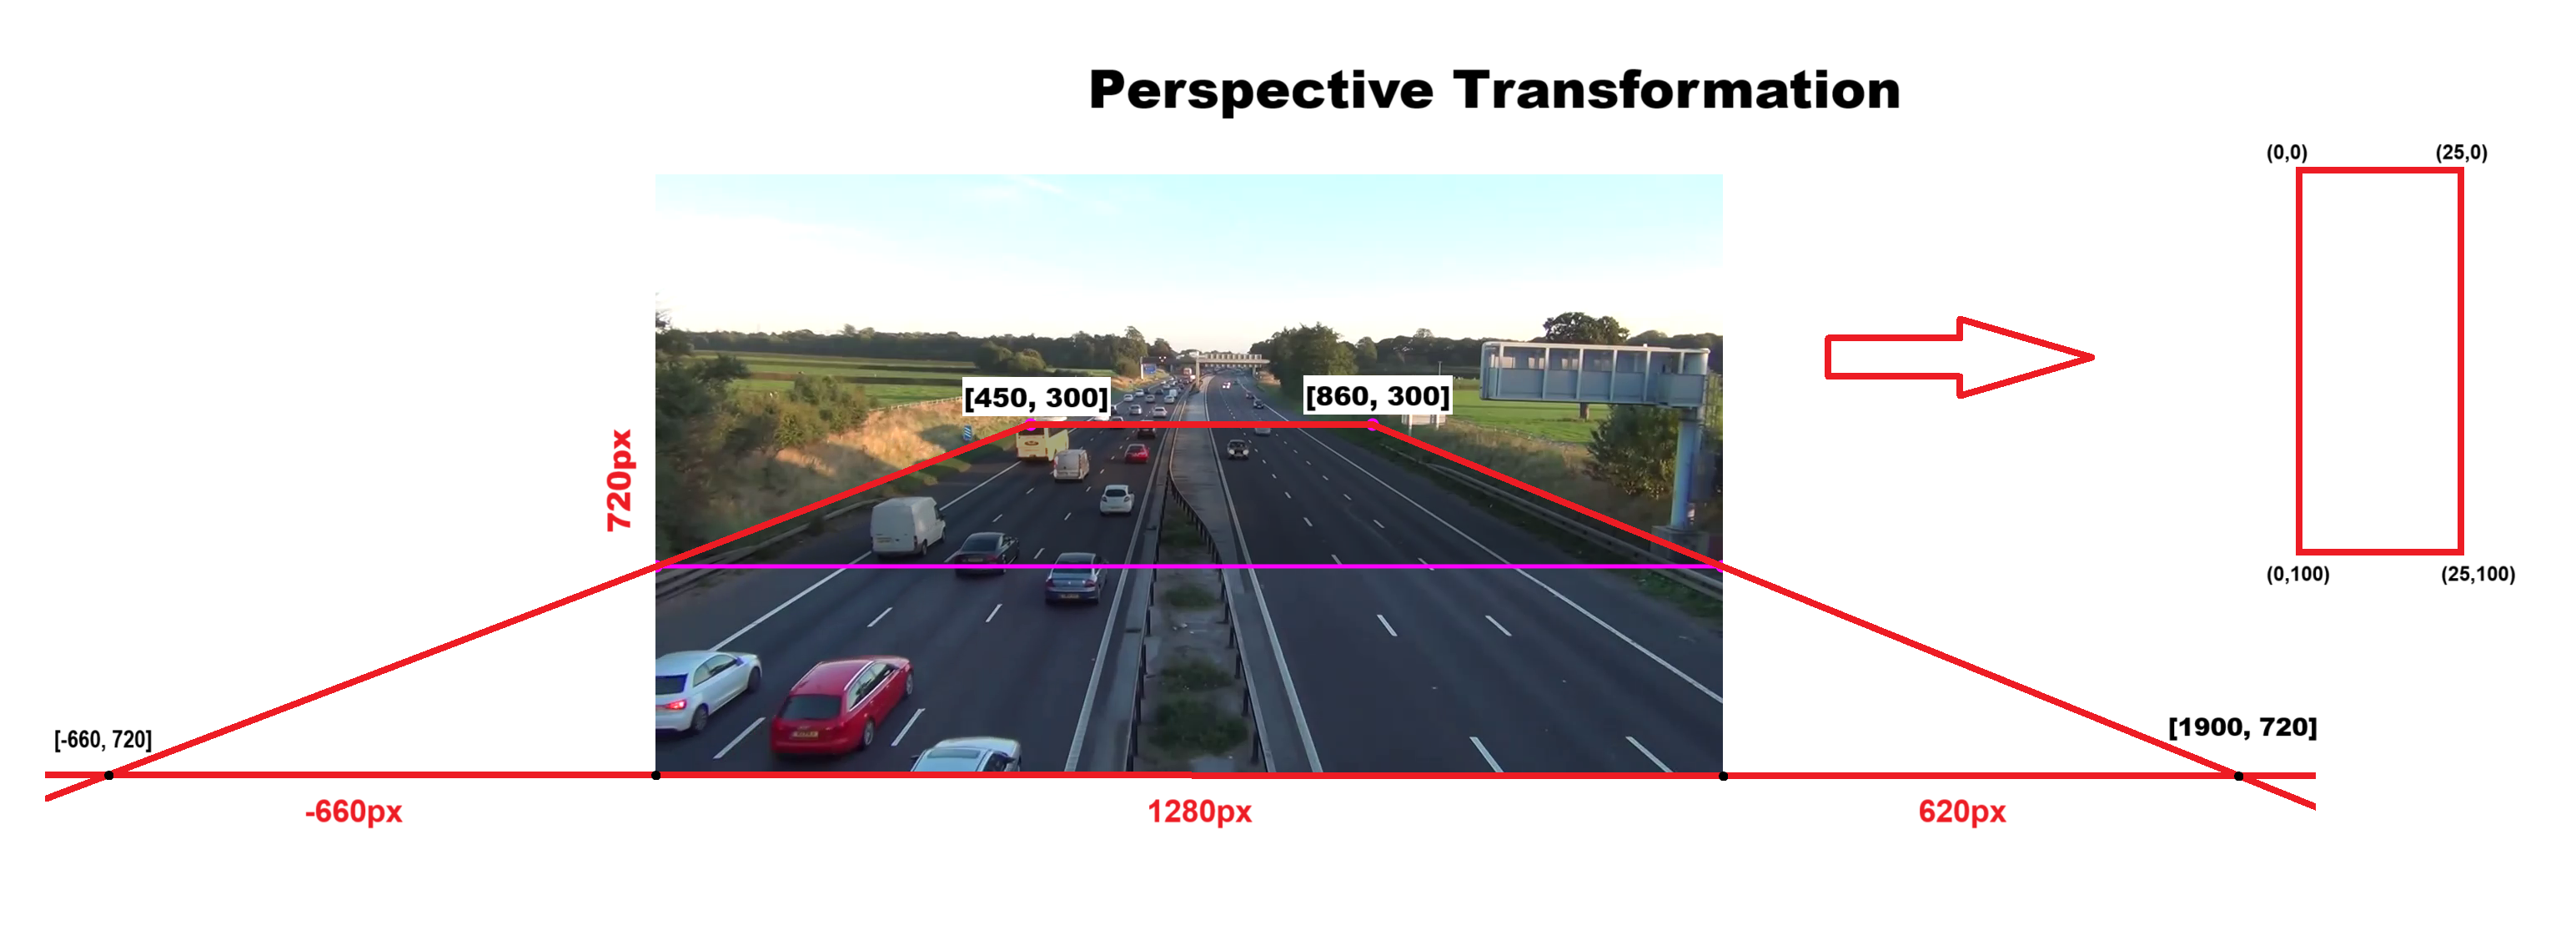


---


### [Speed Estimator Class](src\speed_estimator.py)


In [2]:
import numpy as np
from collections import defaultdict, deque
import supervision as sv


class SpeedEstimator:
    """
    Estimates object speed based on movement across frames using perspective transformation.
    """

    def __init__(
        self,
        fps: int,
        view_transformer: ViewTransformer,
        max_history_seconds: int = 1,
    ):
        """
        Args:
            fps (int): Video frames per second.
            view_transformer (ViewTransformer): Instance for perspective transformation.
            max_history_seconds (int): Max time window to calculate speed (in seconds).
        """
        self.fps = fps
        self.view_transformer = view_transformer
        self.coordinates = defaultdict(
            lambda: deque(maxlen=int(fps * max_history_seconds))
        )

    def calculate_speed(self, tracker_id: int) -> float | None:
        """
        Calculate speed for a specific tracker ID.

        Returns:
            float | None: Speed in km/h if enough data, else None.
        """
        coords = self.coordinates[tracker_id]
        if len(coords) > self.fps / 2:  # Ensure enough movement history
            start, end = coords[0], coords[-1]
            # Euclidean distance in transformed space
            distance = np.linalg.norm(end - start)  # in meters

            time = len(coords) / self.fps  # (N/N) * S = S
            speed = (distance / time) * 3.6  # Convert m/s to km/h
            return int(speed)
        return None

    def update(self, detections: sv.Detections) -> sv.Detections:
        """
        Update object positions and compute speed for current frame.

        Args:
            detections (sv.Detections): Current frame detections.

        Returns:
            sv.Detections: Updated detections with 'speed' in data dictionary.
        """
        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
        points = self.view_transformer.transform_points(points)

        speeds_for_frame = []
        for tracker_id, point in zip(detections.tracker_id, points):
            self.coordinates[tracker_id].append(point)
            speed = self.calculate_speed(tracker_id)
            speeds_for_frame.append(speed if speed else 0)

        detections.data["speed"] = np.array(speeds_for_frame)
        return detections

---


### [Annotator Class](src\annotator.py)


In [3]:
import numpy as np
import supervision as sv


class Annotator:
    """
    A flexible video annotation utility for computer vision pipelines.

    Supports drawing:
    - Bounding boxes
    - Labels
    - Single-class and multi-class line zones
    - Polygon zones
    - Object traces (trajectories)
    """

    def __init__(
        self,
        resolution_wh: tuple[int, int],
        box_annotator: bool = True,
        label_annotator: bool = False,
        line_annotator: bool = False,
        multi_class_line_annotator: bool = False,
        trace_annotator: bool = False,
        trace_length: int = 20,
        polygon_zone=None,
    ):
        """
        Initialize the Annotator with desired annotation settings.

        Args:
            resolution_wh (tuple[int, int]): Video resolution (width, height).
            box_annotator (bool): Enable bounding box annotation.
            label_annotator (bool): Enable label annotation.
            line_annotator (bool): Enable single-class line zone annotation.
            multi_class_line_annotator (bool): Enable multi-class line zone annotation.
            trace_annotator (bool): Enable trajectory annotation for tracked objects.
            trace_length (int): Maximum number of positions to keep for traces.
            polygon_zone (list[tuple[int, int]], optional): Polygon zone coordinates.
        """
        self.thickness = sv.calculate_optimal_line_thickness(resolution_wh)
        self.text_scale = sv.calculate_optimal_text_scale(resolution_wh)

        # Initialize annotators
        self.box_annotator = (
            sv.BoxAnnotator(thickness=self.thickness) if box_annotator else None
        )
        self.label_annotator = (
            sv.LabelAnnotator(
                text_thickness=self.thickness,
                text_scale=self.text_scale,
                text_position=sv.Position.BOTTOM_CENTER,
            )
            if label_annotator
            else None
        )
        self.line_annotator = (
            sv.LineZoneAnnotator(
                thickness=self.thickness,
                text_thickness=self.thickness,
                text_scale=self.text_scale,
            )
            if line_annotator
            else None
        )
        self.multi_class_line_annotator = (
            sv.LineZoneAnnotatorMulticlass(
                text_thickness=self.thickness,
                text_scale=self.text_scale,
            )
            if multi_class_line_annotator
            else None
        )
        self.trace_annotator = (
            sv.TraceAnnotator(thickness=self.thickness, trace_length=trace_length)
            if trace_annotator
            else None
        )
        self.polygon_annotator = (
            sv.PolygonZoneAnnotator(
                zone=sv.PolygonZone(polygon_zone),
                thickness=self.thickness,
                color=sv.Color.GREEN,
                display_in_zone_count=False,
            )
            if polygon_zone is not None
            else None
        )

    def annotate(
        self,
        frame: np.ndarray,
        detections: sv.Detections,
        labels: list[str] | None = None,
        line_zones: list[sv.LineZone] | None = None,
        multi_class_zones: list[sv.LineZone] | None = None,
    ) -> np.ndarray:
        """
        Annotate a video frame with selected features.

        Args:
            frame (np.ndarray): The video frame to annotate.
            detections (sv.Detections): Detection objects for annotation.
            labels (list[str], optional): Labels for objects.
            line_zones (list[sv.LineZone], optional): Single-class line zones.
            multi_class_zones (list[sv.LineZone], optional): Multi-class line zones.

        Returns:
            np.ndarray: Annotated video frame.
        """
        annotated_frame = frame.copy()

        # Draw bounding boxes
        if self.box_annotator:
            annotated_frame = self.box_annotator.annotate(annotated_frame, detections)

        # Draw labels
        if self.label_annotator:
            annotated_frame = self.label_annotator.annotate(
                annotated_frame, detections, labels=labels
            )

        # Draw traces (trajectories)
        if self.trace_annotator:
            annotated_frame = self.trace_annotator.annotate(annotated_frame, detections)

        # Draw line zones (single-class)
        if self.line_annotator and line_zones:
            for zone in line_zones:
                annotated_frame = self.line_annotator.annotate(
                    annotated_frame, line_counter=zone
                )

        # Draw multi-class line zones
        if self.multi_class_line_annotator and multi_class_zones:
            annotated_frame = self.multi_class_line_annotator.annotate(
                annotated_frame, line_zones=multi_class_zones
            )

        # Draw polygon zone
        if self.polygon_annotator:
            annotated_frame = self.polygon_annotator.annotate(annotated_frame)

        return annotated_frame

---


## **Main Execution**


---


### [Configuration File](config.py)


In [4]:
# Configuration File

# Define Video Paths
IN_VIDEO_PATH = "./data/vehicles.mp4"
OUT_VIDEO_PATH = "./data/vehicles_output.mp4"

# YOLO Model Path
# To switch to a custom model, update the path below
# YOLO_MODEL_PATH = "./models/yolov8n.pt"
YOLO_MODEL_PATH = "./models/VisDrone_YOLO_x2.pt"

# Line Zone for counting vehicles (in pixels)
LINE_Y = 480

# Perspective Transform Points
# SOURCE_POINTS: Points in the original image
# TARGET_POINTS: Corresponding points in the top-down view (real-world mapping)
SOURCE_POINTS = [[450, 300], [860, 300], [1900, 720], [-660, 720]]
WIDTH, HEIGHT = 25, 100  # Dimensions in meters
TARGET_POINTS = [[0, 0], [WIDTH, 0], [WIDTH, HEIGHT], [0, HEIGHT]]

# Display Window Settings
WINDOW_NAME = "Detection + Tracking + Counting + Speed Estimation"

---


### [Initialization and Setup](main.py)


In [5]:
import cv2
import numpy as np
import supervision as sv
from ultralytics import YOLO

In [6]:
# Load YOLO Model
model = YOLO(YOLO_MODEL_PATH)

In [7]:
# Get Video Info
video_info = sv.VideoInfo.from_video_path(IN_VIDEO_PATH)
print(video_info)

VideoInfo(width=1280, height=720, fps=30, total_frames=942)


In [8]:
# Initialize Tracker
tracker = sv.ByteTrack(frame_rate=video_info.fps)

In [9]:
# Define Line Zone for counting
offset = 55
start, end = sv.Point(offset, LINE_Y), sv.Point(video_info.width - offset, LINE_Y)
line_zone = sv.LineZone(start, end, minimum_crossing_threshold=1)

In [10]:
# Define Perspective Transform source & target points
SOURCE = np.array(SOURCE_POINTS)
TARGET = np.array(TARGET_POINTS)

# Initialize ViewTransformer
view_transformer = ViewTransformer(SOURCE, TARGET)

# Initialize SpeedEstimator
speed_estimator = SpeedEstimator(fps=video_info.fps, view_transformer=view_transformer)

In [11]:
# Initialize Annotator
annotator = Annotator(
    resolution_wh=video_info.resolution_wh,
    box_annotator=True,
    label_annotator=True,
    line_annotator=True,
    multi_class_line_annotator=True,
    trace_annotator=True,
    polygon_zone=SOURCE,
)

In [12]:
# Initialize Window
cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_NORMAL)
cv2.resizeWindow(WINDOW_NAME, video_info.width, video_info.height)

---


### [Main Processing Loop](main.py)


In [13]:
frame_generator = sv.get_video_frames_generator(IN_VIDEO_PATH)

# Video writer
with sv.VideoSink(OUT_VIDEO_PATH, video_info) as sink:
    for frame in frame_generator:
        # YOLO Detection
        results = model(frame, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(results)

        # Apply Tracker
        detections = tracker.update_with_detections(detections)

        # Apply Line Zone Counting
        line_zone.trigger(detections)

        # Estimate Speed
        detections = speed_estimator.update(detections)

        # Create Labels: ID + Class  + Speed
        labels = []
        for tracker_id, class_name, speed in zip(
            detections.tracker_id,
            detections.data["class_name"],
            detections.data["speed"],
        ):
            text = f"{class_name} #{tracker_id}"
            if speed != 0:
                text = f"{class_name} {speed}km/h"
            labels.append(text)

        # Annotate Frame
        annotated_frame = annotator.annotate(
            frame,
            detections,
            labels=labels,
            line_zones=[line_zone],
            multi_class_zones=[line_zone],
        )

        # Write frame to output video
        sink.write_frame(frame=annotated_frame)

        # Show real-time display
        cv2.imshow(WINDOW_NAME, annotated_frame)

        # Check if 'q' pressed or window closed
        if (
            cv2.waitKey(1) & 0xFF == ord("q")
            or cv2.getWindowProperty(WINDOW_NAME, cv2.WND_PROP_VISIBLE) < 1
        ):
            break


cv2.destroyAllWindows()

# Final Output
print("Processing complete.")
print(f"Processed video saved at: {OUT_VIDEO_PATH}")
print(f"Total vehicles counted: {line_zone.in_count + line_zone.out_count}", end=" | ")
print(f"(In: {line_zone.in_count}, Out: {line_zone.out_count})")
print(f"Model used: {YOLO_MODEL_PATH}")

Processing complete.
Processed video saved at: ./data/vehicles_output.mp4
Total vehicles counted: 23 | (In: 15, Out: 8)
Model used: ./models/VisDrone_YOLO_x2.pt


---
